# Music Sentiment Analysis
### by Ben Pfeffer

In [1]:
from IPython.display import HTML

In [30]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this project is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Intro 
What emotions are expressed most commonly in the lyrics of popular music in the US? What emotions are less popular? Are different emotions correlated with one another? In this project I will analyze the emotional content of music lyrics in the popular music of the last 50 years. 

Keep in mind that I am only analyzing the emotional content of the *lyrics*, not the *melodies* in this project. Analyzing music while totally disregarding the melody is at best incomplete, so take everything you read here with a grain of salt. Sometimes the missing melody may be [amplifying](https://www.youtube.com/watch?v=4fWyzwo1xg0) the lyrical emotions explored here. Other times the tune [contrasts](https://www.youtube.com/watch?v=unfzfe8f9NI) with the lyrics, acting as an emotional counterpoint or overriding the lyrics altogether. There is lots of research being done in the interplay between [music and lyrics](https://www.researchgate.net/publication/247733383_Songs_and_emotions_Are_lyrics_and_melodies_equal_partners) that warrants further investigation. I think this project can provide valuable insight into what emotions Americans are explicitly indulging in through the musical lyrics, but even in the best case scenario this is only half the picture. 

This project was inspired by two data science projects I read about on the internet. The first is Greg Rafferty's [Sentiment Analysis on the Texts of Harry Potter](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-sentiment-analysis-1b474b13651d). The second is John W. Miller's [Trucks and Beer üç∫](https://www.johnwmillr.com/trucks-and-beer/). I decided to do a bit of a combination of the two, performing a similar sentiment analysis as Rafferty, but using Miller's Genius API wrapper to scrape lyrics from many musical artists. 

 The Billboard Hot 100 Artists is a year-end list of the most successful and prominent artists of the year. It measures record sales, radio airtime, and (for newer artists) internet streaming in the US. The lists for all years ranging between 1970 and 2019 are available online. For this reason I believe these lists will allow us to build a good sample of the most popular music in the US. One advantage to this approach is that it will allow us to get historical data from artists back before streaming was popular (Spotify wouldn't be able to tell us who people were listening to in the 70's). One limitation to this approach is that it only gives us data about the very top of the pyramid. There is still tons of music that is very popular in the US made by artists who have never made a Billboard Hot 100 Artists list. There is a risk that the emotional content of many of those artist's lyrics is significantly different than the emotional content of the artists at the top. 


 ## Data Wrangling 
 To begin, I scraped the Billboard Hot 100 artists for each year from 1970 to 2019 using the BeautifulSoup package. Then I deleted all the duplicates (for example, Michael Jackson was on the list for much of the 80's). I was left with a list of 1540 musical artists who were popular in the US for at least one year between 1970 and 2019. Some are staples of popular music, while others are more one hit wonders. The code for this section is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/scrape-artists.py). 
 
 Next, I wanted to gather the lyrics for the most popular songs by each artist. I used John W. Miller's Genius API wrapper to search for songs by each of the 1540 artists. I limited my search to the 25 most popular songs by each artist, as determined by the Genius algorithm. Many artists have less than 25 songs available, but for expediency's sake I did not search for every song by artists with more than 25 songs. The lyrics are cleaned to remove punctuation, stop words (words like "a," "the," "of," "and" etc), and convert everything to lower case. The code for this is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/gather-lyrics.py).  
 
 It was convenient to write the previous section as a JSON file, but I wanted to work with a data frame, so I converted the JSON file to a CSV. The code for that piece is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/json-to-csv.py).
 

## Methodology 
 Now that I have the artist and lyrics in a nicely formatted data frame, it is time to do the sentiment analysis. I used the [NRC Emotion Lexicon](https://nrc.canada.ca/en/research-development/products-services/technical-advisory-services/sentiment-emotion-lexicons) to ascribe emotions to musical lyrics. The NRC Lexicon has word-emotion associations for eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) as well as a general positive or negative sense. For example, the word "vindictive" is associated with "anger," "disgust," and "negative." The word "fondness" is associated with "joy" and "positive." Each word is scored either a 0 (not associated) or a 1 (associated) with each emotion. The lexicon has over 25,000 words classified in this way.
 
 For an artist in the data frame, I gave them a scorecard for each emotion. I looked at each word in the list of lyrics and cross referenced the NRC lexicon for emotional associations. Any time there was a match I added a point to the appropriate emotion(s) for the artist. This process is repeated for each artist in the data frame. Since different artists have very different word counts, I divide the artist's score for each emotion by their total word count. This gives us a percentage of the artist's lyrics (after stop words are removed) associated with each emotion in the NRC lexicon. We also calculate the number of unique words and the lyrical diversity (unique words/total words) for each artist. 
 
 The code for this section is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/sentiment-analysis.py). We started with 1540 artists and searched for lyrics related to each of them. Some did not return anything, and we dropped those artists. We are left with 1463 artists in our final data frame. Below is the first five rows of our final dataset. 
 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
%matplotlib inline

df = pd.read_csv('sentiment-data-clean.csv', index_col='index')

# store length of original df for use later
orig_len = len(df)
# display first 5 rows of df
df.head().round(3)
df.sort_values('Word Count', ascending=False).head(1)

Artist  \
index                                  
973    Jonathan Edwards (Theologian)   

                                                  Lyrics  Word Count  \
index                                                                  
973    deuteronomy xxxii 35 foot shall slide due time...       26517   

       Unique Words  Lyrical Diversity  positive  negative     anger  \
index                                                                  
973            4344           0.163819  0.156541  0.052645  0.023758   

       anticipation   disgust    fear       joy   sadness  surprise     trust  
index                                                                          
973        0.099144  0.021609  0.0712  0.087717  0.028397  0.030886  0.123921

## Findings 

One of the first visualizations I made gave me two informative outliers. The graph below plots total Word Count against Unique Words. As you would expect, artists with higher word counts tend to have more unique words.  

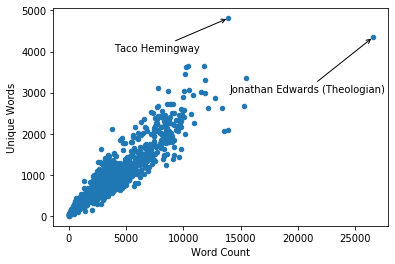

In [37]:
df.plot(kind='scatter', x='Word Count', y='Unique Words')
plt.annotate('Jonathan Edwards (Theologian)', xy=(26517, 4344), xytext=(14000, 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('Taco Hemingway', xy=(13903, 4810), xytext=(4000, 4000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
print('')

 Taco Hemingway has more unique words than any other artist, and much more than you would expect given his wordcount. The reason for this is that Hemingway is a Polish rapper. Polish presumably has more unique words than english, perhaps because of conjugations. I used a stemmer to convert words into their base words (for example, 'running' becomes 'run' and 'curtains' becomes 'curtain'), but this stemmer only went looking for english words and probably made no changes to the Polish words. The emotion lexicon, likewise only recognized English words, so we expect Taco Hemingway's lyrics to show up as less emotional than average. 

In [32]:
df.sort_values('Unique Words', ascending=False).head(1)

Artist                                             Lyrics  \
index                                                                      
889    Taco Hemingway  teraz porozmawiajmy pieniƒÖdzach zauwa≈ºyli≈õcie ...   

       Word Count  Unique Words  Lyrical Diversity  positive  negative  \
index                                                                    
889         13903          4810           0.345968  0.009135  0.002733   

          anger  anticipation   disgust     fear      joy   sadness  surprise  \
index                                                                           
889    0.003596       0.00374  0.000719  0.00151  0.00784  0.001151  0.007337   

          trust  
index            
889    0.003668

Indeed, Hemingway's lyrics are counted as highly unemotional by the algorithm. 

Now, I have never heard of Taco Hemingway, and I was surprised a Polish rapper made it on an American hot music list. After some investigation, I found that Taco Hemingway has never been on the Hot 100 Artists list, but there was an artist called Taco who had a hit in 1983 and made the list. Taco does not appear in my data. I think what happened was that when I queried the Genius API for Taco, it gave me the 25 most popular songs by any artist with Taco in their name, and Taco Hemingway happens to be more popular than Taco from the 80's. 

In the same way, I'm very certain that Jonathan Edwards (Theologian), a theologian from the colonial era, did not make the Billboard Hot 100 in the last 50 years. There was a musical artist with the same name who had a hit in 1971. When the Genius API was queried it gave me data on the theologian, presumable because the theologian has an audiobook that is more popular than the musician's work. 

It seems that the code allows for gathering lyrics from artists that are close but not exact matches to the original artist. This is something that I would like to see if I can fix in a future version of this project, but for now I do not think it will skew the results so much that I need to re-code the project before I look at the results. We will proceed with the analysis.

But first, let's take a small detour into the writings of Jonathan Edwards (Theologian). Since the "lyrics" data returned for Edwards is a chunk of his writing, he tallied up a far higher word count than any of the musicians. Since Edwards wrote in English we can take a look at how the algorithm ranked the emotionality of his work. 

Edwards is best known for his sermon "Sinners in the Hands of an Angry God."  The sermon is famous for its vivid imagery of hell and for scaring crowds of people into a sudden fervor. He is seen as representative of colonial Calvinist theology in his descriptive focus on heaven and hell as real, physical places. Edwards is credited with being a major figure in starting the First Great Awakening in US history. 

In [38]:
df.sort_values('Word Count', ascending=False).head(1)

Artist  \
index                                  
973    Jonathan Edwards (Theologian)   

                                                  Lyrics  Word Count  \
index                                                                  
973    deuteronomy xxxii 35 foot shall slide due time...       26517   

       Unique Words  Lyrical Diversity  positive  negative     anger  \
index                                                                  
973            4344           0.163819  0.156541  0.052645  0.023758   

       anticipation   disgust    fear       joy   sadness  surprise     trust  
index                                                                          
973        0.099144  0.021609  0.0712  0.087717  0.028397  0.030886  0.123921

The emotional content of his work scores highly on positivity, trust, anticipation, joy, and fear. Other negative emotions have low scores. Edward's sermons seem to be generally from human's perspective on heaven and hell, rather than from God's perspective. So it makes sense that emotions like anger, disgust, and sadness are deemphasized, as those would be more likely to be associated with God's feelings towards humans in Edward's theology. 

However, for someone who is primarily associated with his vivid hell imagery, I was surprised at how much more positivity was in his work (heaven) than negativity (hell). Overall, the emotional analysis seems like it roughly matches the themes of his work, so I take this as good news that the algorithm is doing what it set out to do. 

We drop Edwards from the data since he is not a musician, but keep Taco Hemingway. We also drop any artist with fewer than 500 total words, as the small sample size may cause misleading results.

In [39]:
# we remove Jonathan Edwards the theologian
df = df[df.Artist !=  'Jonathan Edwards (Theologian)']

# we also remove artists with fewer than 500 unique words
# (small sample size artists may have randomly high emotion values)
df = df[df['Word Count'] > 500]

# how many entries have we removed in this way? 
removed_rows = orig_len - len(df)
print("Removed " + str(removed_rows) + " artists. " + str(len(df)) + " remaining.")

Removed 94 artists. 1369 remaining.


Now let's find out whether positivity and negativity are expressed in equal amounts. 

The positive emotions mean is 0.088. 
The negative emotions mean is 0.068


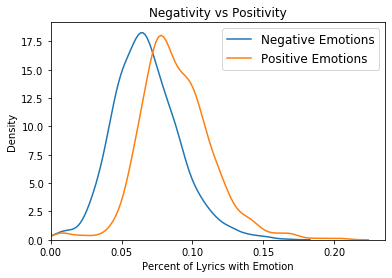

In [41]:
sns.distplot(df['negative'], hist=False, label='Negative Emotions')
sns.distplot(df['positive'], hist=False, label='Positive Emotions')
plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Negativity vs Positivity')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')  

pos_mean = df['positive'].mean().round(3)
neg_mean = df['negative'].mean().round(3)

print('The positive emotions mean is ' + str(pos_mean) + 
      '. \nThe negative emotions mean is ' + str(neg_mean))

It certainly appears that positive emotions are expressed more often than negative emotions. We can use a two sample t-test to formalize this conclusion. 

In [59]:
t, p = stat.ttest_rel(df['positive'], df['negative'])
if p < 0.05:
    print('With a p-value of ' + str('{:0.2e}'.format(p)) +
          ', the difference in the means is statistically significant.')
elif p > 0.05:
    print('With a p-value of ' + str('{:0.2e}'.format(p)) + 
      ', the difference in the means is not statistically significant.')

With a p-value of 4.53e-78, the difference in the means is statistically significant.


The chance that we would see a result as extreme or more extreme than this one based just on random luck is vanishingly small. The mean increase--from 0.068 to 0.086--is almost a 30% increase, and this distance seems to be fairly uniform throughout the distribution. We can conclude that positive emotions are expressed about 30% more often than negative emotions in our population. 

Now let's take a closer look at the individual emotions. We'll start with the negative emotions. 

Anger mean: 0.03
Disgust mean: 0.022
Fear mean: 0.037
Sadness mean: 0.039


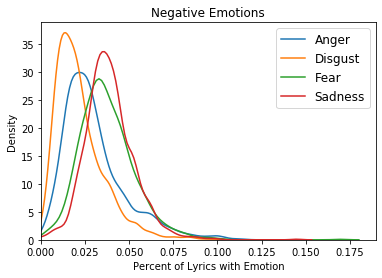

In [46]:
sns.distplot(df['anger'],   hist=False, label='Anger')
sns.distplot(df['disgust'], hist=False, label='Disgust')
sns.distplot(df['fear'],    hist=False, label='Fear')
sns.distplot(df['sadness'], hist=False, label='Sadness')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Negative Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')

anger_mean = df['anger'].mean().round(3)
disgust_mean = df['disgust'].mean().round(3)
fear_mean = df['fear'].mean().round(3)
sadness_mean = df['sadness'].mean().round(3)

print('Anger mean: ' + str(anger_mean) + 
     '\nDisgust mean: ' + str(disgust_mean) + 
     '\nFear mean: ' + str(fear_mean) + 
     '\nSadness mean: ' + str(sadness_mean))

Disgust seems to be the least commonly expressed of the negative emotions. We should use a statistical test to ensure that this is not just random noise, but first let's take a look at the positive emotions. 

Joy mean: 0.059
Surprise mean: 0.027
Anticipation mean: 0.052
Trust mean: 0.046


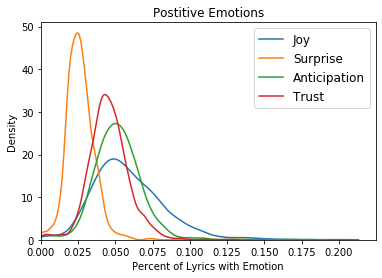

In [47]:
sns.distplot(df['joy'], hist=False, label='Joy')
sns.distplot(df['surprise'], hist=False, label='Surprise')
sns.distplot(df['anticipation'], hist=False, label='Anticipation')
sns.distplot(df['trust'], hist=False, label='Trust')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Postitive Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density') 

joy_mean = df['joy'].mean().round(3)
surprise_mean = df['surprise'].mean().round(3)
anticipation_mean = df['anticipation'].mean().round(3)
trust_mean = df['trust'].mean().round(3)

print('Joy mean: ' + str(joy_mean) + 
     '\nSurprise mean: ' + str(surprise_mean) + 
     '\nAnticipation mean: ' + str(anticipation_mean) + 
     '\nTrust mean: ' + str(trust_mean))

We would like to investigate whether the observed differences in the means for each of the emotions are significantly different. The standard statistical practice is to run an ANOVA test first. This will tell us whether any of the emotion pairs have significantly different means, or whether all the variation is plausibly attributable to random noise. We run that test below.  

In [62]:
# ANOVA test
f, p = stat.f_oneway(df['joy'], 
                     df['surprise'],
                     df['anticipation'],
                     df['trust'],
                     df['anger'],
                     df['disgust'],
                     df['fear'],
                     df['sadness'])
if p < 0.05:
    print('The p-value for the ANOVA test is ' + str(p) + 
          '. This is a statistically significant value. \nWe conclude that there is at least one ' +
         'significant difference between the means.')
elif p > 0.05:
    print('The p-value for the ANOVA test is ' + str(p) + 
          '. This is not a statistically significant value. \nThe difference in the means ' + 
          'may be due to random noise.')

The p-value for the ANOVA test is 0.0. This is a statistically significant value. 
We conclude that there is at least one significant difference between the means.


 The ANOVA test affirms that at least one pair is significantly different, but it does not tell us which pair or pairs are significant. We use the Pairwise Tukey HSD test to test all emotion pairs, because this test will automatically adjust our p-values to control the type I error rate. 

In [49]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['Artist'], 
                   value_vars = ['joy', 'surprise','anticipation', 'trust',
                                 'anger','disgust','fear','sadness'])

# replace column names
df_melt.columns = ['Artist', 'Emotion', 'value']

multi_comp = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['Emotion'], 
                               alpha=0.05)
print(multi_comp)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
       anger anticipation   0.0212  0.001  0.0193   0.023   True
       anger      disgust  -0.0084  0.001 -0.0103 -0.0066   True
       anger         fear   0.0072  0.001  0.0053   0.009   True
       anger          joy   0.0282  0.001  0.0263  0.0301   True
       anger      sadness   0.0086  0.001  0.0067  0.0104   True
       anger     surprise  -0.0038  0.001 -0.0057 -0.0019   True
       anger        trust   0.0152  0.001  0.0134  0.0171   True
anticipation      disgust  -0.0296  0.001 -0.0315 -0.0278   True
anticipation         fear   -0.014  0.001 -0.0159 -0.0122   True
anticipation          joy    0.007  0.001  0.0052  0.0089   True
anticipation      sadness  -0.0126  0.001 -0.0145 -0.0108   True
anticipation     surprise   -0.025  0.001 -0.0268 -0.0231   True
anticipation        trust

All pairwise comparisons are statistically significant except for fear-sadness. The means of all other emotion pairs are due to underlying differences in the amounts they are expressed; random noise is an implausible explanation.

However, statistical significance is not the same as practical significance. With our large sample size it is very possible that we are detecting statistical significance that the average person would never notice. For example, look at the disgust-surprise pair. The difference in their means is only 0.0046. On average surprise appears in 2.7% of lyrics and disgust appears in 2.2% of lyrics. . Would the average music listener really notice a difference? Let's unpack that question.

Interestingly, the while the means of disgust and surprise are very close, the shapes of the distributions are somewhat different. This is something that the statistical test will not pick up, but is worth discussing.


Surprise mean: 0.027
Disgust mean: 0.022


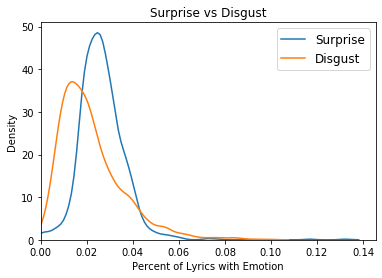

In [50]:
sns.distplot(df['surprise'], hist=False, label='Surprise')
sns.distplot(df['disgust'], hist=False, label='Disgust')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Surprise vs Disgust')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density') 

print('Surprise mean: ' + str(surprise_mean) +
      '\nDisgust mean: ' + str(disgust_mean))

The peaks of the two distributions are in different places, but their means (that is, their center of mass) close to equal.

The distribution of surprise is tall and symmetrical. We see that almost everybody displays surprise in between 1.5% and 4% of their lyrics. This matches with my intuition on the nature of surprise. Nobody can be surprised very often (otherwise it wouldn't be much of a surprise), but everybody is surprised sometimes (otherwise they would have to always be right or else not think at all about the future).

Disgust, on the other hand, has a wider distribution with a right skew. Some artists almost never display disgust. Others are disgusted quite often. Six artists emote disgust with more than 8% of their lyrics. Twenty-two artists emote disgust with less than 0.5% of their lyrics (to be fair, a few of those artists may have an artificially low ratio because their lyrics are in a different language). This also matches my intuition. Some people are very rarely dsgusted. They seem to accept most things as they are. Others are disgusted quite often and demand some change to be made.

The fact that the algorithm picked up these differences in distributions that match with basic intuition about how human emotions work gives me confidence that the algorithm is doing what it was disigned to do.

As to the original question of whether people would notice a practical difference in the amount of disgust and surprise in their music, my suspicion is that it depends on the person. I would think that many people would gravitate to music with higher or lower levels of disgust to match their personal preferences. Surprise, on the other hand, seems more universal and harder to pick and choose. It seems likely to me that some people are exposed to more disgust than surprise in their music, while others are exposed to more surprise than disgust, and that they have some degree of agency in selecting music that matches their preferences. 

As a final point of exploration, let's look at the correlations between all the different emotions. Which emotions are strongly correlated? 


In [51]:
df.corr().style.background_gradient(cmap='coolwarm', axis=None, low=.25).set_precision(2)

Here are a few of the tidbits I found interesting from this chart. **Keep in mind that correlation is not causation!**

- Word Count and Unique Words are moderately correlated with anger and disgust, and moderately inversely correlated with joy. More words, more anger and disgust, and less joy
- Lyrical Diversity (that is, Unique Words/Word Count) is not strongly correlated with any emotion
- the positive emotions are correlated with other positive emotions. The negative emotions are correlated with other negative emotions
- The positive and negative emotions do not have a very strong inverse correlation with each other. The positive correlations are stronger than the negative correlations. The presence of negativity does not imply a lack of positivity, and vice versa
- The strongest inverse correlation is between joy and Unique words. Other positive emotions have negative correlations to Word Cound and Unique Words. The happier artists say less

## Conclusion 
I would like to suggest some potential improvements and follow up projects to build on this one. 
- tweak the Genuis API search function to make sure we get the right artists (Jonathan Edwards, Theologian)
- discard artists and lyrics who primarily perform in non-English languages (Taco Hemingway)
- scrape Billboard Top 100 Songs per year (this project scraped the Hot 100 Artists). With this data you could track the emotional content of popular song lyrics over time. 
    - Which emotions are more prevalent in which time periods? 
    - Can we see a difference in emotional content during recessions, wartime, or other difficult historical periods? 
- take one artist and emotionally classify each album & compare 
    - how has the emotional composition of Beyonce's work changed throughout her career? 
